In [ ]:
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [56]:
# Model parameters
params = {'eta': 1.5 * np.ones(2), 'gamma': 10.0, 'q': 1.5}


In [57]:
# ---------- model parameters ----------

tau_logit    = params.get('gamma', 1.0)
gamma_unif   = params.get('gamma', 1.0)
gamma_pareto = params.get('gamma', 1.0)
q_pareto     = params.get('q', 1.5)
eta = np.ones(2)


def softmax(z):
    z = np.asarray(z, dtype=float)
    z = z - np.max(z)  # numerical stability
    e = np.exp(z)
    return e / e.sum()


def sparsemax(z):
    z = np.asarray(z, dtype=float)
    z_sorted = np.sort(z)[::-1]
    z_cumsum = np.cumsum(z_sorted)
    k = np.arange(1, z.size + 1)
    cond = 1 + k * z_sorted > z_cumsum
    k_star = np.where(cond)[0][-1] + 1
    tau = (z_cumsum[k_star - 1] - 1.0) / k_star
    return np.maximum(z - tau, 0.0)


def tsallis_br(u, gamma, q, eta=None, tol=1e-12, max_iter=200):
    u = np.asarray(u, dtype=float)
    N = u.size
    if eta is None:
        eta = np.ones(N)
    eta = np.asarray(eta, dtype=float)
    if gamma <= 0 or q <= 1:
        raise ValueError("Require gamma>0 and q>1")

    c = (q - 1.0) / (gamma * q)
    power = 1.0 / (q - 1.0)

    def S(tau):
        return float(np.sum(eta * np.maximum(0.0, c * (u - tau)) ** power))

    u_max = float(np.max(u))
    u_min = float(np.min(u))

    hi = u_max               # S(hi) = 0
    lo = u_min - 1.0
    span = (u_max - u_min) + 1.0
    while S(lo) < 1.0:
        lo -= 2.0 * span
        if lo < u_min - 1e9:
            break

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        s = S(mid)
        if abs(s - 1.0) <= tol:
            tau = mid
            break
        if s > 1.0:
            lo = mid
        else:
            hi = mid
        tau = mid

    p = eta * np.maximum(0.0, c * (u - tau)) ** power
    if p.sum() == 0:
        p = np.zeros(N)
        p[np.argmax(u)] = 1.0
    else:
        p = p / p.sum()
    return p


def fixed_point(U1, U2, br1, br2, max_iter=20000, tol=1e-4, damping=0.5):
    # Solve p1 = br1(U1 p2), p2 = br2(U2^T p1) by damped iteration.
    N = U1.shape[0]
    p1 = np.ones(N) / N
    p2 = np.ones(N) / N
    for it in range(max_iter):
        u1 = U1 @ p2
        u2 = U2.T @ p1
        b1 = br1(u1)
        b2 = br2(u2)
        new_p1 = (1 - damping) * p1 + damping * b1
        new_p2 = (1 - damping) * p2 + damping * b2
        if np.linalg.norm(new_p1 - p1, 1) + np.linalg.norm(new_p2 - p2, 1) < tol:
            return new_p1, new_p2
        p1, p2 = new_p1, new_p2
    return p1, p2


def rmse(pred, obs):
    pred = np.asarray(pred)
    obs  = np.asarray(obs)
    return float(np.sqrt(np.mean((pred - obs) ** 2)))


In [58]:
# ---------- Trajectory plot: fix one game, vary gamma ----------
from scipy.optimize import least_squares

GAME_IDX = 0          # pick a game 0..4  (AMP 1..5)
GAMMAS = np.logspace(-2, 3, 200)   # sweep range for gamma
Q_PARETO_TRAJ = q_pareto           # reuse the q from params

# --- BR dispatcher (same as notebook, but parameterised by gamma) ---
def br_vector(u, gamma, kind, q_par, eta_vec):
    """Return probability vector over 2 actions."""
    if kind == "logit":
        return softmax(u / gamma)
    if kind == "uniform":
        p = sparsemax(u / (2.0 * gamma))
        s = p.sum()
        if s <= 0:
            p = np.zeros_like(p); p[np.argmax(u)] = 1.0
        else:
            p = p / s
        return p
    if kind == "pareto":
        return tsallis_br(u, gamma=gamma, q=q_par, eta=eta_vec)
    raise ValueError(kind)

# --- Bounded least-squares solver with warm start (from visual.py) ---
def solve_fp_2x2(U1, U2, gamma, kind, q_par, eta_vec,
                  init=(0.5, 0.5), tol=1e-12, max_nfev=5000):
    """Solve p = BR_row(U1 q), q = BR_col(U2^T p) via least_squares."""
    def F(x):
        p0, q0 = x
        pv = np.array([p0, 1.0 - p0])
        qv = np.array([q0, 1.0 - q0])
        p_br = br_vector(U1 @ qv, gamma, kind, q_par, eta_vec)[0]
        q_br = br_vector(U2.T @ pv, gamma, kind, q_par, eta_vec)[0]
        return np.array([p0 - p_br, q0 - q_br])

    inits = [init, (0.5, 0.5), (0.9, 0.9), (0.1, 0.1),
             (0.9, 0.1), (0.1, 0.9)]
    best, best_err = None, np.inf
    for x0 in inits:
        x0 = np.clip(np.array(x0, dtype=float), 0.0, 1.0)
        res = least_squares(F, x0=x0, bounds=(0.0, 1.0),
                            ftol=tol, xtol=tol, gtol=tol, max_nfev=max_nfev)
        err = float(np.linalg.norm(res.fun, ord=1))
        if err < best_err:
            best_err, best = err, res
        if best_err < 1e-10:
            break
    p0, q0 = best.x
    return np.array([p0, 1.0 - p0]), np.array([q0, 1.0 - q0])



In [ ]:
# ---------- Synthetic game: asymmetric matching pennies ----------
# Row wants to coordinate (large payoffs), Col wants to mismatch (small payoffs).
from IPython.display import display, Markdown

# U1_syn = np.array([[1500.,    0.],
#                     [   0., 500.]])
# U2_syn = np.array([[   0.,  45.],
#                     [  48.,   0.]])


# U1_syn = np.array([[0.,    500.],
#                     [  160., 0.]])
# U2_syn = np.array([[   0.,  40.],
#                     [  500.,   0.]])

U1_syn = np.array([[0.,    300.],
                    [  160., 0.]])
U2_syn = np.array([[   0.,  40.],
                    [  300.,   0.]])


T = max(max(U1_syn.flatten()), max(U2_syn.flatten()))
U1_syn = U1_syn / T
U2_syn = U2_syn / T


# Mixed NE:  p1* = 48/(45+48) ≈ 0.516,  q1* = 500/(4000+500) ≈ 0.111
# Row gap at q=0.5:  (4000-500)/2 = 1750  (huge → sparsemax snaps)
# Col gap at p=0.5:  (48-45)/2   = 1.5   (tiny → stays interior)

# Payoff table
df_syn = pd.DataFrame(
    [[(f"({U1_syn[r,c]:.2f}, {U2_syn[r,c]:.2f})") for c in range(2)]
     for r in range(2)],
    index=["Row A", "Row B"],
    columns=["Col A", "Col B"],
)
display(Markdown("**Synthetic game payoffs  (Row, Col)**"))
display(df_syn)

# Nash equilibria
G_syn = nash.Game(U1_syn, U2_syn)
eqs = list(G_syn.support_enumeration())
display(Markdown("**Nash equilibria**"))
for k, (p, q) in enumerate(eqs):
    tag = "mixed" if p.min() > 1e-10 and q.min() > 1e-10 else "pure"
    print(f"  NE {k+1} ({tag}):  p = [{p[0]:.4f}, {p[1]:.4f}],  "
          f"q = [{q[0]:.4f}, {q[1]:.4f}]")

# Payoff gap analysis
a, d = U1_syn[0,0], U1_syn[1,1]
f_, g_ = U2_syn[0,1], U2_syn[1,0]
print(f"\nRow gap at q=0.5:  (a-d)/2 = {(a-d)/2:.0f}")
print(f"Col gap at p=0.5:  (g-f)/2 = {(g_-f_)/2:.1f}")
print(f"Gap ratio: {(a-d)/(g_-f_):.0f}x  →  Row hits boundary, Col stays interior")

**Synthetic game payoffs  (Row, Col)**

,Col A,Col B
Row A,"(0.00, 0.00)","(1.00, 0.13)"
Row B,"(0.53, 1.00)","(0.00, 0.00)"


**Nash equilibria**

  NE 1 (pure):  p = [1.0000, 0.0000],  q = [0.0000, 1.0000]
  NE 2 (pure):  p = [0.0000, 1.0000],  q = [1.0000, 0.0000]
  NE 3 (mixed):  p = [0.8824, 0.1176],  q = [0.6522, 0.3478]

Row gap at q=0.5:  (a-d)/2 = 0
Col gap at p=0.5:  (g-f)/2 = 0.4
Gap ratio: 0x  →  Row hits boundary, Col stays interior


In [60]:
# ============================================================
# Synthetic game: SE-OB vs QRE trajectories
# ============================================================
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

# Mixed NE (unique — no pure NE in this game)
G_syn  = nash.Game(U1_syn, U2_syn)
eqs    = list(G_syn.support_enumeration())
p_ne_s, q_ne_s = [(p, q) for p, q in eqs
                   if p.min() > 1e-10 and q.min() > 1e-10][0]
ne_syn = (p_ne_s[0], q_ne_s[0])
print(f"Synthetic game  mixed NE = ({ne_syn[0]:.4f}, {ne_syn[1]:.4f})")

# ---------- gamma grid: log-low + linear-mid + log-high ----------
g_low  = np.logspace(-3, 0, 500)         # 0.001 to 1     (log-spaced)
g_mid  = np.linspace(1, 100, 500)        # 1 to 100       (fine linear)
g_high = np.logspace(2, 4, 500)          # 100 to 10000   (log-spaced)
GAMMAS_SYN = np.unique(np.concatenate([g_low, g_mid, g_high]))

Q_PAR_SYN  = q_pareto
eta_syn    = np.ones(2)

paths_syn = {"logit": [], "uniform": [], "pareto": []}

for kind in ["logit", "uniform", "pareto"]:
    init = (0.5, 0.5)
    for g in reversed(GAMMAS_SYN):
        pv, qv = solve_fp_2x2(U1_syn, U2_syn, float(g), kind,
                               Q_PAR_SYN, eta_syn, init=init)
        paths_syn[kind].append([pv[0], qv[0]])
        init = (float(pv[0]), float(qv[0]))
    paths_syn[kind] = np.array(paths_syn[kind])[::-1]



Synthetic game  mixed NE = (0.8824, 0.6522)


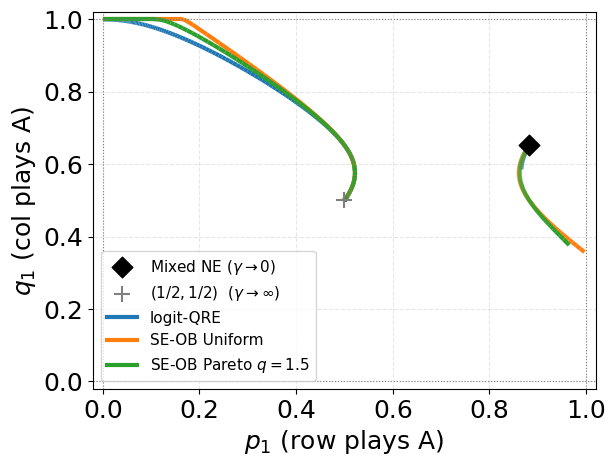

In [61]:
# --- Helper: LineCollection with fixed color, skip jumps ---
def make_lc_color(pts, color, lw=3.0, ls="solid", jump_thresh=0.15):
    """LineCollection with fixed color. Jump segments are transparent."""
    r, g, b = mcolors.to_rgb(color)
    segments, alphas = [], []
    for i in range(len(pts) - 1):
        segments.append([pts[i], pts[i + 1]])
        if np.linalg.norm(pts[i + 1] - pts[i]) > jump_thresh:
            alphas.append(0.0)
        else:
            alphas.append(1.0)
    segments = np.array(segments)
    rgba = np.column_stack([np.full(len(segments), r),
                            np.full(len(segments), g),
                            np.full(len(segments), b),
                            np.array(alphas)])
    lc = LineCollection(segments, colors=rgba, linewidths=lw, linestyles=ls)
    return lc

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.02)
# ax.set_xlim(0.5-0.02, 1.02); ax.set_ylim(-0.02, 0.62)
ax.set_xlabel(r"$p_{1}$ (row plays A)")
ax.set_ylabel(r"$q_{1}$ (col plays A)")
ax.grid(True, linestyle="--", alpha=0.3)

# NE marker (unique mixed NE — no pure NE in this game)
ax.scatter(*ne_syn, marker="D", s=110, c="k", label=r"Mixed NE ($\gamma\to 0$)", zorder=5)
ax.scatter(0.5, 0.5, marker="+", s=140, c="gray",
           label=r"$(1/2,1/2)$  ($\gamma\to\infty$)", zorder=4)

# Per-model color
model_cfg = {
    "logit":   {"color": "C0", "ls": "solid", "lw": 3.0,
                "label": r"logit-QRE"},
    "uniform": {"color": "C1", "ls": "solid", "lw": 3.0,
                "label": r"SE-OB Uniform"},
    "pareto":  {"color": "C2", "ls": "solid", "lw": 3.0,
                "label": rf"SE-OB Pareto $q={Q_PAR_SYN:.1f}$"},
}

for kind, cfg in model_cfg.items():
    lc = make_lc_color(paths_syn[kind], color=cfg["color"],
                       lw=cfg["lw"], ls=cfg["ls"])
    ax.add_collection(lc)
    ax.plot([], [], color=cfg["color"], ls=cfg["ls"], lw=cfg["lw"],
            label=cfg["label"])

# boundary
for v in [0, 1]:
    ax.axhline(v, color="gray", lw=0.8, ls=":")
    ax.axvline(v, color="gray", lw=0.8, ls=":")

# ax.set_title(r"SE-OB vs QRE trajectories")
ax.legend(loc="lower left", fontsize=11)
plt.tight_layout()

out_png = "trajec_g2.png"  # change name as needed
fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()